In [1]:
#load dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#load in the collected data
df2006 = pd.read_json('dataframes/df2006.json')
df2007 = pd.read_json('dataframes/df2007.json')
df2008 = pd.read_json('dataframes/df2008.json')
df2009 = pd.read_json('dataframes/df2009.json')

In [3]:
#combine the data into one dataframe, check for data types and null values
df = df2006.append(df2007.append(df2008.append(df2009)))
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14770 entries, c1e4o to c0i10ti
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   score             14770 non-null  int64 
 1   controversiality  14770 non-null  int64 
 2   subreddit         14770 non-null  object
 3   body              14770 non-null  object
 4   month             14770 non-null  int64 
 5   year              14770 non-null  int64 
 6   original_size     14770 non-null  int64 
 7   PS                14770 non-null  bool  
 8   XBOX              14770 non-null  bool  
dtypes: bool(2), int64(5), object(2)
memory usage: 952.0+ KB


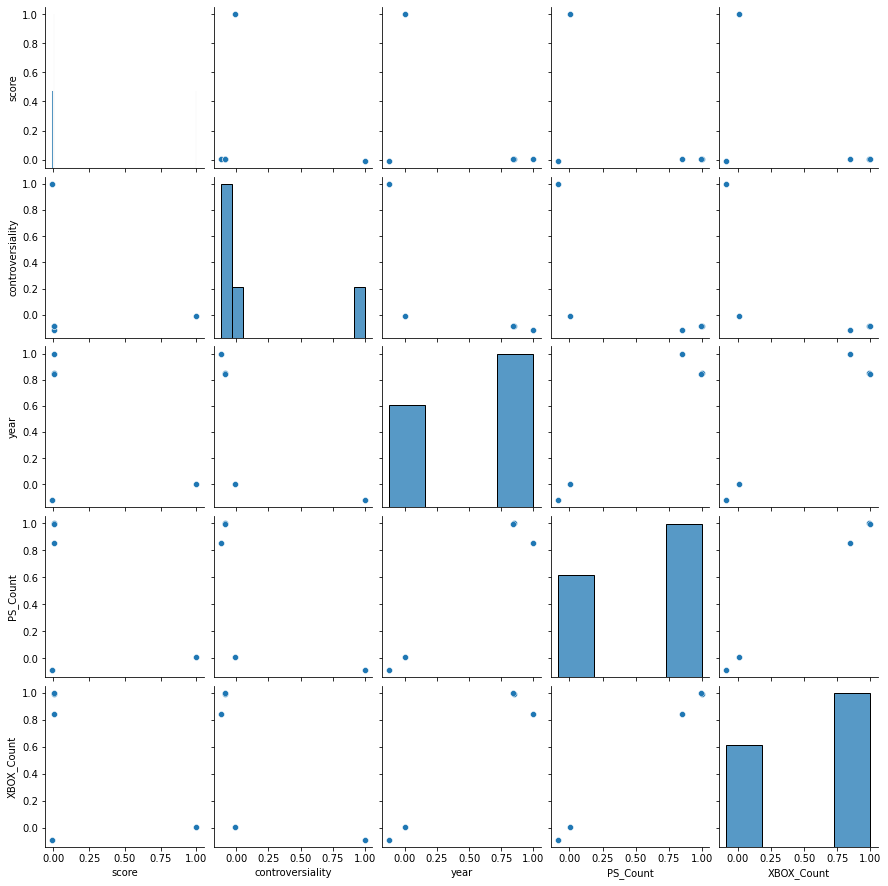

In [47]:
#First let's take a look at the correlation of numeric, boolean, and categorical data.
#The body column is the unique message of each post, and will be explored at a later point.
#In addition, original_size is just the number of posts in that year/month combination and
#will not be useful in looking at correlations.
df['PS_Count'] = df['PS'].cumsum() * 100 / df['original_size']
df['XBOX_Count'] = df['XBOX'].cumsum() * 100 / df['original_size']

corr_df = df[['score', 'controversiality', 'subreddit', 'year', 'PS_Count', 'XBOX_Count']]
sns.pairplot(corr_df.corr())
plt.show()

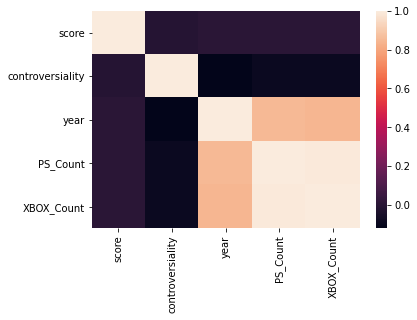

In [48]:
#Not a ton of useful information here.  PS_Count and XBOX_Count are both positively correlated
#with year and each other, as both useage of Reddit since its inception in 2005 and talk of the 
#consoles have increased over the years.  
#What is interesting about that though is that the two count columns are percents of 
#overall Reddit comments, meaning PS and XBOX have become increasing popular topics of conversation.

#As one might expect, controversiality and score are negatively correlated.
#Looking at the heatmap though, they're negatively correlated with everything else as well.
#This is because controversiality only has two values: 0 and 1, the former appearing over 14k times
#while the latter only shows up 15 times, all of which were in 2006 and 2007.
#Score, meanwhile has a wide variance, with about 11k/14.5k entries being between 0 and 4 but overall
#ranging from -45 to 398.
sns.heatmap(corr_df.corr())
plt.show()

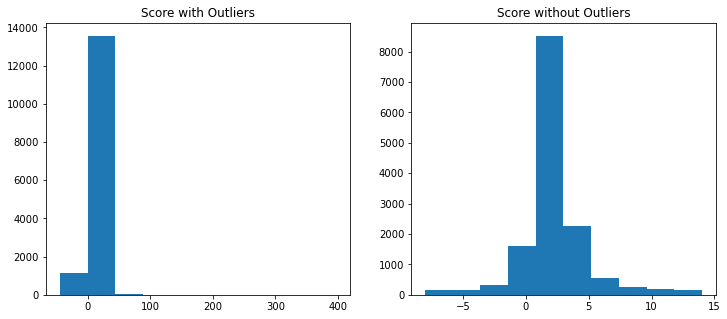

In [64]:
#Just to visualize how many outliers score has.
figs, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs[0].hist(df['score'])

m = df['score'].mean()
std = df['score'].std()
axs[1].hist(df['score'][(df['score'] >= (m-std)) & (df['score'] <= (m+std))])

axs[0].set_title('Score with Outliers')
axs[1].set_title('Score without Outliers')
plt.show()

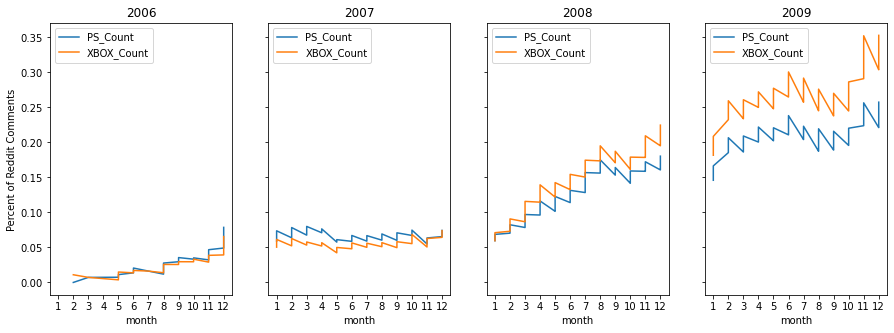

In [4]:
#plotting Counts of XBOX and PS against time
#I only have year/month data for time, so I'm splitting by year, rather than making a time series

figs, axs = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(15,5))

_ = df[df['year']==2006].plot(x='month', y=['PS_Count', 'XBOX_Count'], ax=axs[0])
_ = df[df['year']==2007].plot(x='month', y=['PS_Count', 'XBOX_Count'], ax=axs[1])
_ = df[df['year']==2008].plot(x='month', y=['PS_Count', 'XBOX_Count'], ax=axs[2])
_ = df[df['year']==2009].plot(x='month', y=['PS_Count', 'XBOX_Count'], ax=axs[3])


axs[0].set_title('2006')
axs[1].set_title('2007')
axs[2].set_title('2008')
axs[3].set_title('2009')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
figs.text(0.09, 0.5, 'Percent of Reddit Comments', ha='center', va='center', rotation='vertical')
axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')
axs[2].legend(loc='upper left')
axs[3].legend(loc='upper left')
plt.show()

In [5]:
#Plots above are separated by year of counts per month (hence the step function appearance).
#Both sets scale exponentially due to more frequent use of Reddit as time goes on, 
#hence the percentage of mentions rather than count.
#It looks like PS initially had more mentions, but XBOX eventually took over in early 2008.
#Percent of Reddit Comments are all less than 1% for clarification.

In [6]:
#plotting Counts by Subreddit

#create a filtering mask to only show subreddits that have more than 10 mentions apiece to avoid an oversized graph
subreddit_mask = df['subreddit'].value_counts() > 10
subreddit_mask.replace(False, np.nan, inplace=True)
subreddit_mask.dropna(inplace=True)
subreddit_df = df[df['subreddit'].isin(subreddit_mask.index)]

subreddit_df['PS_Subreddit_Count'] = subreddit_df['subreddit']
subreddit_df['XBOX_Subreddit_Count'] = subreddit_df['subreddit']
for subreddit in subreddit_mask.index:
    base_df = subreddit_df[subreddit_df['subreddit']==subreddit]
    ps_sub = base_df[base_df['PS']==True]
    xbox_sub = base_df[base_df['XBOX']==True]
    ps_count = ps_sub['PS'].count()
    xbox_count = xbox_sub['XBOX'].count()

    subreddit_df['PS_Subreddit_Count'].replace(subreddit, str(ps_count), inplace=True)
    subreddit_df['XBOX_Subreddit_Count'].replace(subreddit, str(xbox_count), inplace=True)
    
subreddit_df['PS_Subreddit_Count'] = subreddit_df['PS_Subreddit_Count'].astype(int)
subreddit_df['XBOX_Subreddit_Count'] = subreddit_df['XBOX_Subreddit_Count'].astype(int)

<ipython-input-6-6190ae284e5f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_df['PS_Subreddit_Count'] = subreddit_df['subreddit']
<ipython-input-6-6190ae284e5f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_df['XBOX_Subreddit_Count'] = subreddit_df['subreddit']
C:\Users\rlybb\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

<ipython-input-50-281cf78354da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_df.sort_values(by='XBOX_Subreddit_Count', inplace=True, ascending=False)


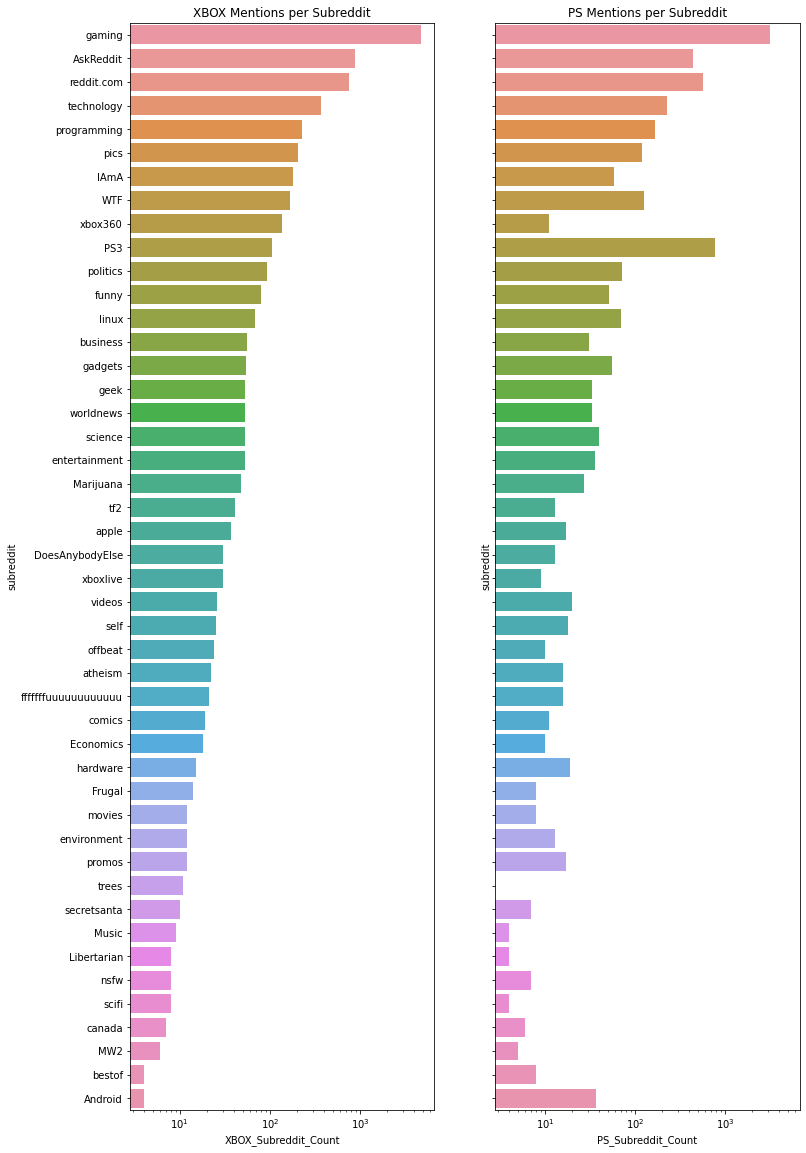

In [50]:
subreddit_df.sort_values(by='XBOX_Subreddit_Count', inplace=True, ascending=False)

figs, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 20))
sns.barplot(x='XBOX_Subreddit_Count', y='subreddit', data=subreddit_df, ax=axs[0])
axs[0].set_title('XBOX Mentions per Subreddit')
axs[0].set_xscale('log')

sns.barplot(x='PS_Subreddit_Count', y='subreddit', data=subreddit_df, ax=axs[1])
axs[1].set_title('PS Mentions per Subreddit')
plt.show()

In [8]:
#The above barplots separate number of mentions by subreddit.  
#Unsurprisingly, Gaming is the most popular subreddit for both XBOX and PS, 
#followed by PS3 for PS, askreddit and reddit.com, technology, and programming.
#note that reddit.com is a placeholder for posts before subreddits were created in 2008.
#Once again, the data is shown on a logarithmic scale due to the exponential behavior of posts on Reddit.